# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 

In [211]:
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

In [212]:
#concatinatig features with target
raw_df = pd.concat([X, y], axis = 1) 

In [213]:
df = raw_df.copy(deep = True)

# EDA & Feature engineering

Let's see the first five rows

In [214]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


I want to see what is the shape of my data set

In [215]:
print('Shape of df:' ,df.shape)

Shape of df: (48842, 15)


I want to see my features in the list

In [216]:
df.columns.to_list()

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'income']

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [218]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [219]:
df.income.value_counts()

<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: income, dtype: int64

#### According to the point above :
>In the income column:
>
>>class '>50k' and '>50k.' are same.
>>
>>class '<=50k' and '<=50k.' are same.

In [220]:
df.loc[df['income'] == '<=50K.', 'income'] = '<=50K'
df.loc[df['income'] == '>50K.', 'income'] = '>50K'

In [221]:
df['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

# Handeling Missing values

Let's check that this dataset has missing value or not

In [222]:
df.isna().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

This dataset has null value
>columns :
>
>'workclass'(obj), 'occupation'(obj) and 'native-country'(obj) have missing value


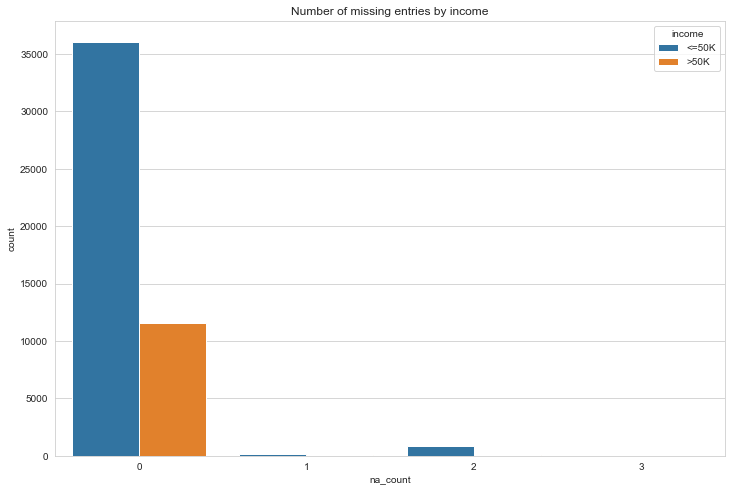

In [223]:
df['na_count'] = df.isna().sum(axis = 1)
plt.figure(figsize = (12, 8))
sns.countplot(data = df, x = 'na_count', hue = 'income')
plt.title('Number of missing entries by income')
df.drop('na_count', axis = 1, inplace = True)

Most of the missing values belong to income<= 50k

Filling categorical columns by Simpleimputer and most frequent strategy

In [224]:
def impute(data, columns, strategy = 'most_frequent'):
    """
    fill missing value in each column with specific strategy
    
        input :
            data : orginal dataset.
            columns : columns that have missing value. 
            strategy :it is different depending on the data type of each column.

        output: dataset with out missing value
    """
    imputer = SimpleImputer(strategy = strategy)
    data[columns] = imputer.fit_transform(data[columns])
    return data

In [225]:
impute_df = df.copy(deep = True)
categorcal_columns = ['workclass','occupation','native-country']

impute(impute_df, categorcal_columns, strategy = 'most_frequent')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,Private,321403,HS-grad,9,Widowed,Prof-specialty,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [226]:
impute_df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

We don't have any missing value

In [227]:
impute_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


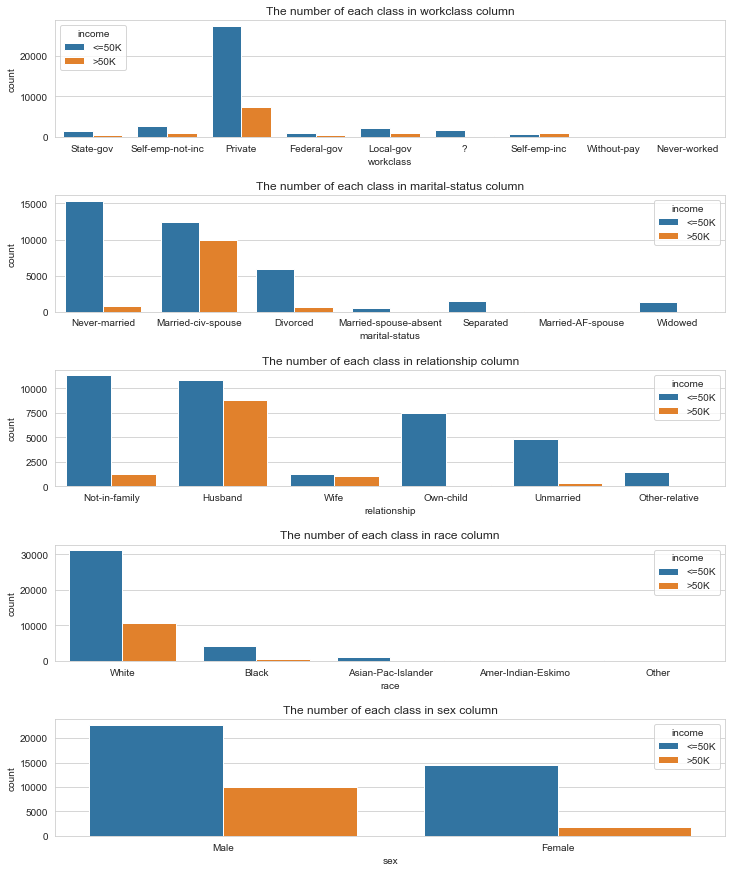

In [230]:
plt.figure(figsize = (12, 15))

#countplot
plt.subplot(5,1,1)
sns.countplot(data = impute_df, x = 'workclass', hue = 'income')
plt.title('The number of each class in workclass column')

plt.subplot(5,1,2)
sns.countplot(data = impute_df, x = 'marital-status', hue = 'income')
plt.title('The number of each class in marital-status column')

plt.subplot(5,1,3)
sns.countplot(data = impute_df, x = 'relationship', hue = 'income')
plt.title('The number of each class in relationship column')

plt.subplot(5,1,4)
sns.countplot(data = impute_df, x = 'race', hue = 'income')
plt.title('The number of each class in race column')

plt.subplot(5,1,5)
sns.countplot(data = impute_df, x = 'sex', hue = 'income')
plt.title('The number of each class in sex column')
plt.subplots_adjust(hspace=0.5)


Descriptions of above plots:
>1.The number of people with incomes less than 50 thousand dollars is more than those with incomes more than 50 thousand dollars.
>
>2.The highest incomes belong to those who have private jobs.
>
>3.The number of single people with incomes less than 50 thousand dollars is much more than those with incomes more than 50 thousand dollars.
>
>4.The white race has more incomes than other races.
>
>5.Men have more incomes than women.

Text(0.5, 1.0, 'Target distribution')

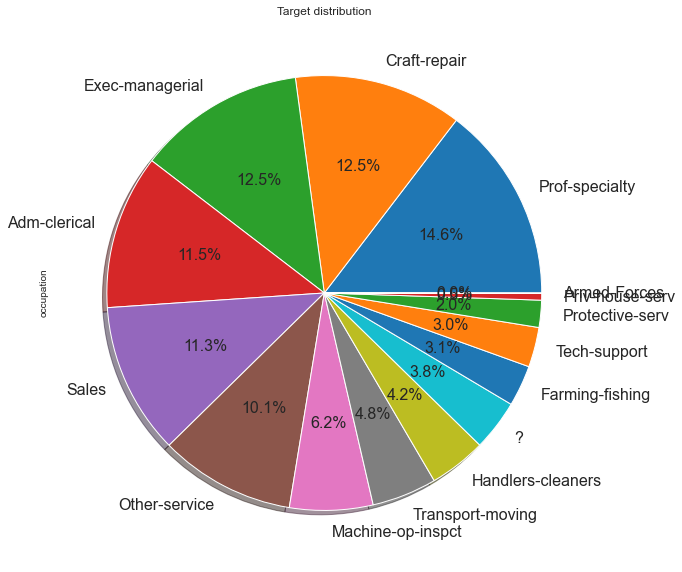

In [181]:
plt.figure(figsize=(10,10))

# Pie plot
impute_df['occupation'].value_counts().plot.pie(autopct='%1.1f%%', 
    shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

Text(0.5, 1.0, 'Target distribution')

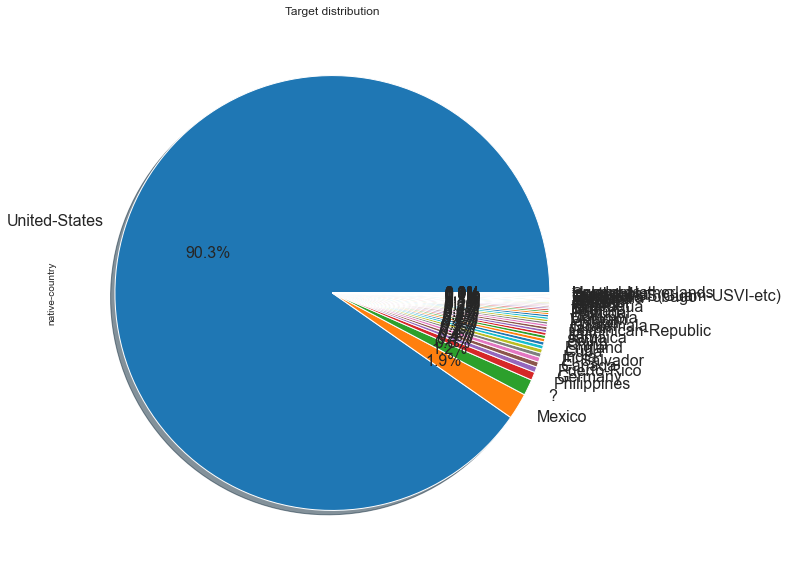

In [182]:
plt.figure(figsize=(10,10))

# Pie plot
impute_df['native-country'].value_counts().plot.pie(autopct='%1.1f%%', 
    shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

<AxesSubplot:xlabel='income', ylabel='count'>

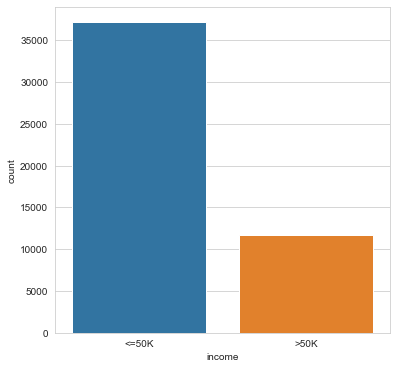

In [183]:
plt.figure(figsize = (6, 6))
sns.countplot(data = impute_df, x = 'income')

Oooh ,in this step we found 2 key point:
>1.In three column ('workclass', 'occupation' and 'native-country' ) we have value of "?".
>
>2.The dataset is imbalance.




In [232]:
#replace '?' with 'nan'
df['workclass']=df['workclass'].replace('?',np.nan)
df['occupation']=df['occupation'].replace('?',np.nan)
df['native-country']=df['native-country'].replace('?',np.nan)

In [233]:
#Again impute categorical classes
impute_df = df.copy(deep = True)
categorcal_columns = ['workclass','occupation','native-country']

impute(impute_df, categorcal_columns, strategy = 'most_frequent')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,Private,321403,HS-grad,9,Widowed,Prof-specialty,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [234]:
impute_df['workclass'].value_counts()

Private             36705
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

### Ok, now we don't have any missing values

# Encoding categorical columns

It seems that education-num is encoded of eduation. Let's check it out

In [235]:
print('The number of unique values in the education column:',impute_df['education'].nunique())
print('The number of unique values in the education-num column:',impute_df['education-num'].nunique())

The number of unique values in the education column: 16
The number of unique values in the education-num column: 16


In [236]:
print("The number of each class in education column:")
print("----------------------")
print(impute_df['education'].value_counts())
print('\n')
print("The number of each class in education-num column:")
print("----------------------")
print(impute_df['education-num'].value_counts())

The number of each class in education column:
----------------------
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64


The number of each class in education-num column:
----------------------
9     15784
10    10878
13     8025
14     2657
11     2061
7      1812
12     1601
6      1389
4       955
15      834
5       756
8       657
16      594
3       509
2       247
1        83
Name: education-num, dtype: int64


They are the same. So we can drop education column.

In [237]:
impute_df.drop('education', axis = 1, inplace = True)

Text(0.5, 1.0, 'Histogram')

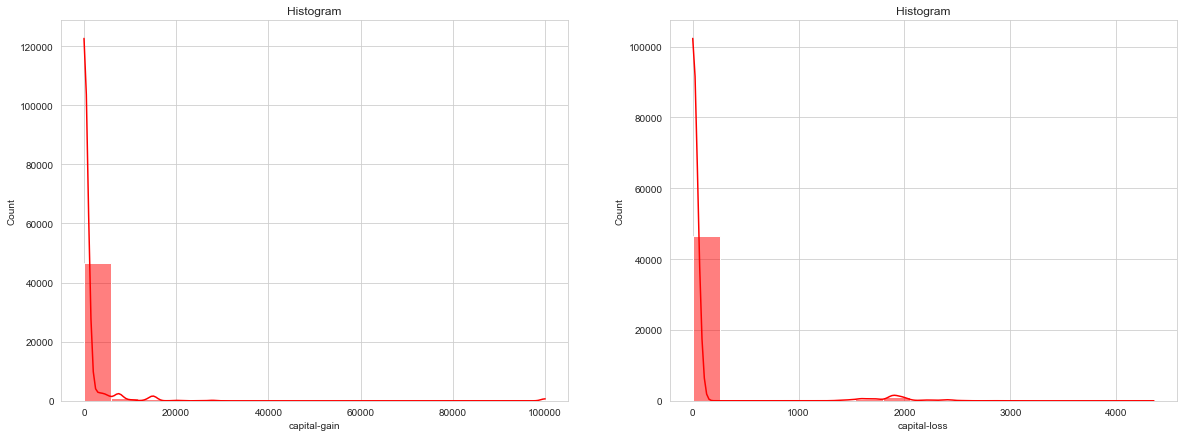

In [238]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
sns.histplot(impute_df['capital-gain'], kde = True,color='r')
plt.title('Histogram')
plt.subplot(1, 2, 2)
sns.histplot(impute_df['capital-loss'], kde = True,color='r')
plt.title('Histogram')

In [239]:
impute_df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


'capital-gain'  &  'capital-loss'  both columns have 75% data as 0.00 So, we can drop 'capital-gain'  & 'capital-loss'  both columns

In [240]:
impute_df = impute_df.drop(['capital-gain', 'capital-loss'], axis=1)

let's convert boolean columns to integers:

In [241]:
impute_df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K


In [242]:
cat_df = impute_df.copy(deep = True)
cat_df['sex'] = cat_df['sex'].astype(bool).astype(int)
cat_df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,1,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,1,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,1,40,United-States,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,40,United-States,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,1,40,Cuba,<=50K


# label encoding

We use the label encoding and frequency baced encoding for categorical classes because the number of classes per feature is large.

In [243]:
label_df = cat_df.copy(deep=True)

label_encoder = OrdinalEncoder()
encode_cat_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country','income']
label_df[encode_cat_cols] = label_encoder.fit_transform(label_df[encode_cat_cols])
label_df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,39,6.0,77516,13,4.0,0.0,1.0,4.0,1,40,38.0,0.0
1,50,5.0,83311,13,2.0,3.0,0.0,4.0,1,13,38.0,0.0
2,38,3.0,215646,9,0.0,5.0,1.0,4.0,1,40,38.0,0.0
3,53,3.0,234721,7,2.0,5.0,0.0,2.0,1,40,38.0,0.0
4,28,3.0,338409,13,2.0,9.0,5.0,2.0,1,40,4.0,0.0


## Frequency-Based Encoding


In [197]:
freq_df = cat_df.copy(deep=True)

def freq_encoding(data, columns):
    for column in columns:
        freq = data[column].value_counts(normalize=True)
        freq_dict = freq.to_dict()

        data[column] = freq_df[column].map(freq_dict)
    return data

freq_df = freq_encoding(freq_df, encode_cat_cols)

freq_df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,39,0.040559,77516,13,0.329982,0.114881,0.257627,0.855043,1,40,0.914971,0.760718
1,50,0.079071,83311,13,0.458192,0.124606,0.403669,0.855043,1,13,0.914971,0.760718
2,38,0.751505,215646,9,0.135805,0.042423,0.257627,0.855043,1,40,0.914971,0.760718
3,53,0.751505,234721,7,0.458192,0.042423,0.403669,0.095922,1,40,0.914971,0.760718
4,28,0.751505,338409,13,0.458192,0.183879,0.047725,0.095922,1,40,0.002825,0.760718


# Training model

In [198]:
X, y = label_df.drop('income', axis = 1), label_df['income']

Data was imbalance so we should balance it with some technique. I use over sampeling.

Also I normalize it with minmaxscaler and I use SVM for classification.

In [206]:
#over sampeling on SVM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)
st =MinMaxScaler()
X_train = st.fit_transform(X_train)
X_test = st.fit_transform(X_test)

svm_model = SVC()
svm_model.fit(X_train, y_train)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
svm_model = SVC()
svm_model.fit(X_train, y_train)

y_predict = svm_model.predict(X_test)

#confusion matrix is suitable  for imbalance data.
print('confusion matrix :\n', confusion_matrix(y_test, y_predict))
print('\n')
print('classification report :\n', classification_report(y_test, y_predict))
print('\n')
print('accuracy score :\n', accuracy_score(y_test, y_predict))
print('\n')
print('precision score:\n', precision_score(y_test, y_predict))
print('\n')
print('recall score :\n', recall_score(y_test, y_predict))
print('\n')
print(' f1 score :\n', f1_score(y_test, y_predict))

confusion matrix :
 [[2714  980]
 [ 164 1027]]


classification report :
               precision    recall  f1-score   support

         0.0       0.94      0.73      0.83      3694
         1.0       0.51      0.86      0.64      1191

    accuracy                           0.77      4885
   macro avg       0.73      0.80      0.73      4885
weighted avg       0.84      0.77      0.78      4885



accuracy score :
 0.7658137154554759


precision score:
 0.5117090184354758


recall score :
 0.8623005877413937


 f1 score :
 0.6422764227642275
